<a href="https://colab.research.google.com/github/EfratCoh/Work3/blob/main/Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the dataset

In [ ]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [ ]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

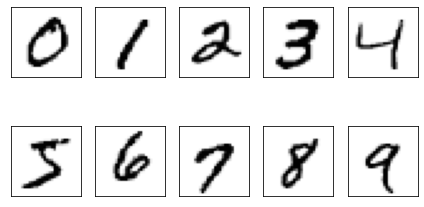

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

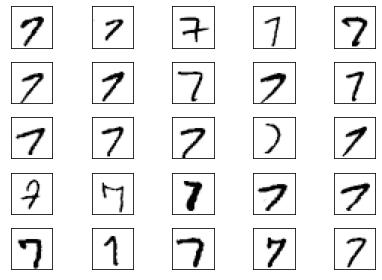

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [ ]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

### Implementing a one-layer perceptron

In [ ]:
import numpy as np

In [ ]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLPOneHidden:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [ ]:
model_1Hidden = NeuralNetMLPOneHidden(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## Implementing a multi-layer perceptron

In [ ]:
import numpy as np

In [ ]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLPTwoHidden:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)

        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_h2 = np.zeros(num_hidden)
        
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer one 
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h1 = np.dot(x, self.weight_h.T) + self.bias_h
        a_h1 = sigmoid(z_h1)


        # Hidden layer two
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1,a_h2, a_out

    def backward(self, x, a_h1,a_h2, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h2
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h2 = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h2 = a_h1
        delta_out2 = d_loss__a_h2 * d_a_h__d_z_h2 # "delta (rule) placeholder"

        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h2 = np.dot((d_loss__a_h2 * d_a_h__d_z_h2).T, d_z_h__d_w_h2)
        d_loss__d_b_h2 = np.sum((d_loss__a_h2 * d_a_h__d_z_h2), axis=0)


        #################################        
        # Part 3: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_h2
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out2, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h1 * (1. - a_h1) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)


        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h2, d_loss__d_b_h2, 
                d_loss__d_w_h, d_loss__d_b_h)

In [ ]:
model_2Hidden = NeuralNetMLPTwoHidden(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [ ]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [ ]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


# 1 hidden model
_, probas = model_1Hidden.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE for 1 hidden: {mse:.1f}')
print(f'Initial validation accuracy for 1 hidden: {acc*100:.1f}%')


# 2 hidden model

_,_, probas = model_2Hidden.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE for 2 hidden: {mse:.1f}')
print(f'Initial validation accuracy for 2 hidden: {acc*100:.1f}%')



Initial validation MSE for 1 hidden: 0.3
Initial validation accuracy for 1 hidden: 9.2%
Initial validation MSE for 2 hidden: 0.2
Initial validation accuracy for 2 hidden: 9.0%


In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100, numer_of_hidden=1):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        if numer_of_hidden==1:
          _, probas = nnet.forward(features)
        else: 
          _,_, probas = nnet.forward(features)

        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
# 1 hidden
mse, acc = compute_mse_and_acc(model_1Hidden, X_valid, y_valid, numer_of_hidden=1)
print(f'Initial valid MSE for one hidden: {mse:.1f}')
print(f'Initial valid accuracy one hidden: {acc*100:.1f}%')

# 2 hidden
mse, acc = compute_mse_and_acc(model_2Hidden, X_valid, y_valid, numer_of_hidden=2)
print(f'Initial valid MSE 2 hidden: {mse:.1f}')
print(f'Initial valid accuracy  2 hidden: {acc*100:.1f}%')

Initial valid MSE for one hidden: 0.3
Initial valid accuracy one hidden: 9.2%
Initial valid MSE 2 hidden: 0.3
Initial valid accuracy  2 hidden: 9.0%


In [ ]:
def train_2Hidden(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h,a_h2,a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__dw_out, d_loss__db_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h, d_loss__d_b_h = \
            model.backward(X_train_mini, a_h,a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__dw_out
            model.bias_out -= learning_rate * d_loss__db_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train, numer_of_hidden=2)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid,numer_of_hidden=2)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [ ]:
def train_1Hidden(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [ ]:
# TRAIN 2 HIDDEN
np.random.seed(123) # for the training set shuffling

epoch_loss_2Hidden, epoch_train_acc_2Hidden, epoch_valid_acc_2Hidden = train_2Hidden(
    model_2Hidden, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)


# TRAIN 1 HIDDEN
np.random.seed(123) # for the training set shuffling

epoch_loss_1Hidden, epoch_train_acc_1Hidden, epoch_valid_acc_1Hidden = train_1Hidden(
    model_1Hidden, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 20.81% | Valid Acc: 20.74%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 26.82% | Valid Acc: 26.68%
Epoch: 003/050 | Train MSE: 0.08 | Train Acc: 31.01% | Valid Acc: 30.58%
Epoch: 004/050 | Train MSE: 0.07 | Train Acc: 50.75% | Valid Acc: 50.86%
Epoch: 005/050 | Train MSE: 0.06 | Train Acc: 62.88% | Valid Acc: 63.08%
Epoch: 006/050 | Train MSE: 0.05 | Train Acc: 70.61% | Valid Acc: 70.60%
Epoch: 007/050 | Train MSE: 0.04 | Train Acc: 79.21% | Valid Acc: 79.32%
Epoch: 008/050 | Train MSE: 0.03 | Train Acc: 84.49% | Valid Acc: 84.82%
Epoch: 009/050 | Train MSE: 0.03 | Train Acc: 86.76% | Valid Acc: 87.00%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 87.76% | Valid Acc: 87.92%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 88.45% | Valid Acc: 88.42%
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 89.08% | Valid Acc: 88.86%
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 89.69% | Valid Acc: 89.58%
Epoch: 014/050 | Train MSE: 0.02 | Train Acc: 90.04

## Evaluating the neural network performance for 2 hidden layer

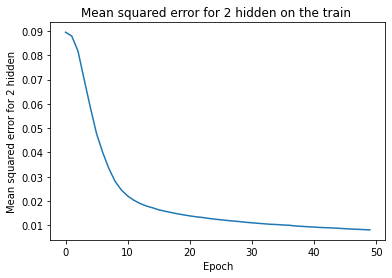

In [ ]:
plt.plot(range(len(epoch_loss_2Hidden)), epoch_loss_2Hidden)
plt.ylabel('Mean squared error for 2 hidden')
plt.xlabel('Epoch')
plt.title("Mean squared error for 2 hidden on the train ")
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

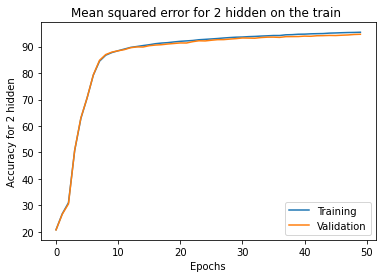

In [ ]:
plt.plot(range(len(epoch_train_acc_2Hidden)), epoch_train_acc_2Hidden,
         label='Training')
plt.plot(range(len(epoch_valid_acc_2Hidden)), epoch_valid_acc_2Hidden,
         label='Validation')
plt.ylabel('Accuracy for 2 hidden')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title("Mean squared error for 2 hidden on the train ")

#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [ ]:
test_mse_2, test_acc_2 = compute_mse_and_acc(model_2Hidden, X_test, y_test, numer_of_hidden=2)
print(f'Test accuracy of 2 hidden: {test_acc_2*100:.2f}%')
print(f'Test mse of 2 hidden: {test_mse_2:.2f}%')

Test accuracy of 2 hidden: 94.42%
Test mse of 2 hidden: 0.01%


In [ ]:
# calculate macro auc 
from sklearn.metrics import roc_auc_score, accuracy_score
import torch.nn.functional as F

X_test_subset = X_test
y_test_subset = y_test

# get the predict of the x_test
_,_, probas = model_2Hidden.forward(X_test_subset)

# Calculate the accuracy 
test_pred = np.argmax(probas, axis=1)
accuracy_2Hidden = accuracy_score(y_test_subset,test_pred)
print('The accuracy is for 2 hidden: ' , accuracy_2Hidden*100, '%')


# Calculate the macro auc 
nehot_targets = int_to_onehot(y_test_subset, num_labels=10)
test_pred=np.concatenate(probas)
y_test_subset=np.concatenate(nehot_targets)

macro_auc_2Hidden = roc_auc_score(y_test_subset,test_pred,average="macro",multi_class="ovr")
print('Macro AUC is for 2 hidden: ' , macro_auc_2Hidden)


The accuracy is for 2 hidden:  94.41904761904762 %
Macro AUC is for 2 hidden:  0.9930674895439657


Plot failure cases for 2 hidden:

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_,_2, probas = model_2Hidden.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

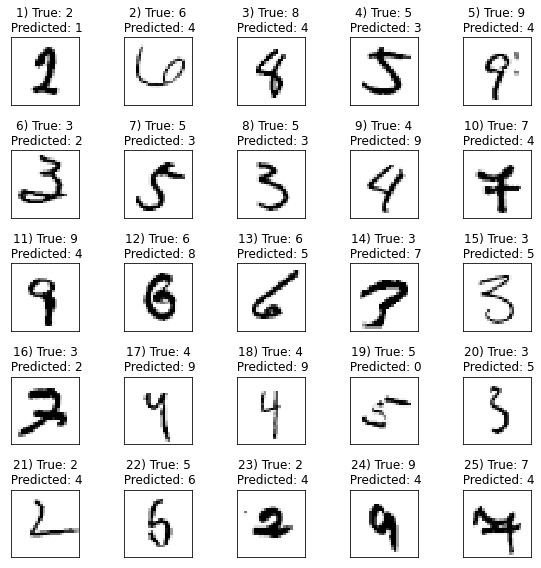

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

## **`Build fully connected ANN implemented inPyTorch `**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,num_features,num_hidden,num_classes):
      super().__init__()
      
      self.fc1 = nn.Linear(num_features, num_hidden)
      self.fc2 = nn.Linear(num_hidden, num_hidden)
      self.out = nn.Linear(num_hidden, num_classes)


    # x represents our data
    def forward(self, x):
      # Pass data through conv1
      x = self.fc1(x)
      # Use the rectified-linear activation function over x
      x = F.sigmoid(x)

      x = self.fc2(x)
      x = F.sigmoid(x)

      # Apply softmax to x
      x = self.out(x)
      output = F.softmax(x)
      return output

In [ ]:
# model new
model_net = Net(num_features=28*28,
                     num_hidden=500,
                     num_classes=10)
print(model_net)



Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=10, bias=True)
)


In [ ]:
import torch.optim as optim
criterion = nn.MSELoss()
# we set the learning rate to 0.1
optimizer = optim.SGD(model_net.parameters(), lr=0.1)
batch_size = 100
EPOCH=50


In [ ]:
# conact the datasets with y label
train_dataset= list(zip(X_train,y_train))
valid_dataset= list(zip(X_valid,y_valid))
test_dataset=  list(zip(X_test,y_test))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
loss_net = []

for epoch in range(EPOCH):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        labels=F.one_hot(labels,10)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # print result for each epoch
    loss_net.append(running_loss / 2000)   
    # print(loss_net) 
    print(f'[{epoch + 1}] loss: {running_loss / 2000:.5f}')
    running_loss = 0.0



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1] loss: 0.01980
[2] loss: 0.01977
[3] loss: 0.01976
[4] loss: 0.01974
[5] loss: 0.01973
[6] loss: 0.01971
[7] loss: 0.01969
[8] loss: 0.01967
[9] loss: 0.01965
[10] loss: 0.01962
[11] loss: 0.01959
[12] loss: 0.01956
[13] loss: 0.01952
[14] loss: 0.01948
[15] loss: 0.01942
[16] loss: 0.01936
[17] loss: 0.01928
[18] loss: 0.01917
[19] loss: 0.01903
[20] loss: 0.01883
[21] loss: 0.01855
[22] loss: 0.01818
[23] loss: 0.01771
[24] loss: 0.01721
[25] loss: 0.01671
[26] loss: 0.01624
[27] loss: 0.01579
[28] loss: 0.01534
[29] loss: 0.01487
[30] loss: 0.01437
[31] loss: 0.01383
[32] loss: 0.01325
[33] loss: 0.01266
[34] loss: 0.01207
[35] loss: 0.01150
[36] loss: 0.01094
[37] loss: 0.01042
[38] loss: 0.00992
[39] loss: 0.00946
[40] loss: 0.00902
[41] loss: 0.00861
[42] loss: 0.00822
[43] loss: 0.00786
[44] loss: 0.00751
[45] loss: 0.00719
[46] loss: 0.00689
[47] loss: 0.00661
[48] loss: 0.00635
[49] loss: 0.00612
[50] loss: 0.00590


## **Evaluate and compere the diffrent netural network**

Evaluate 1 hidden net

In [ ]:
X_test_subset = X_test
y_test_subset = y_test

# get the predict of the x_test
_, probas = model_1Hidden.forward(X_test_subset)

# Calculate the accuracy 
test_pred = np.argmax(probas, axis=1)
accuracy_1Hidden = accuracy_score(y_test_subset,test_pred)
print('The accuracy is for 1 hidden layer: ' , accuracy_1Hidden*100, '%')


# Calculate the macro auc 
nehot_targets = int_to_onehot(y_test_subset, num_labels=10)
test_pred=np.concatenate(probas)
y_test_subset=np.concatenate(nehot_targets)

macro_auc_1Hidden = roc_auc_score(y_test_subset,test_pred,average="macro",multi_class="ovr")
print('Macro AUC is for 1 hidden layer: ' , macro_auc_1Hidden)

The accuracy is:  94.28095238095237 %
Macro AUC is:  0.9927728190980096


Evaluate pytorch net

In [ ]:
# calculate macro auc 
from sklearn.metrics import roc_auc_score, accuracy_score

y_pred=[]
y_true=[]

for i, data in enumerate(testloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    
    labels=F.one_hot(labels,10)

    # forward + backward + optimize
    outputs = model_net(inputs.float())
    loss = criterion(outputs, labels.float())
    # ann predict results
    y_pred.append(outputs.detach().numpy())
    # the true labels
    y_true.append(labels.detach().numpy())

# calculate accuracy
y_pred=np.concatenate(y_pred)
y_true=np.concatenate(y_true)

y_pred_auc=np.argmax(y_pred,axis=1)
y_true_auc=np.argmax(y_true,axis=1)
accuracy_pytorc = accuracy_score(y_true_auc,y_pred_auc)
print('The accuracy  for pytorc: ' , accuracy_pytorc)


macro_auc_pytorc = roc_auc_score(y_true,y_pred,average="macro",multi_class="ovr")
print('Macro AUC for pytorc: ' , macro_auc_pytorc)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The accuracy  for pytorc:  0.8473809523809523
Macro AUC for pytorc:  0.9795453950868165


# **Comparison graph**

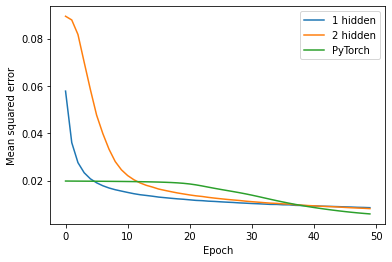

In [ ]:
plt.plot(range(len(epoch_loss_1Hidden)), epoch_loss_1Hidden,  label="1 hidden")
plt.plot(range(len(epoch_loss_2Hidden)), epoch_loss_2Hidden, label="2 hidden")
plt.plot(range(len(loss_net)), [i for i in loss_net], label="PyTorch")

plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.legend(loc="upper right")

#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

Summary accuracy


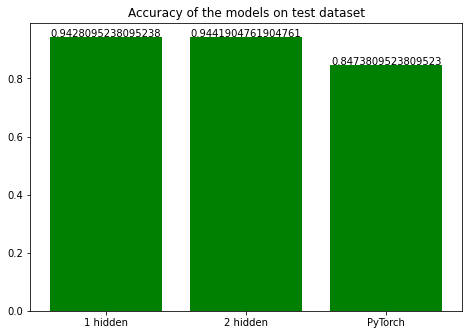

In [ ]:
print("Summary accuracy")
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['1 hidden', '2 hidden', 'PyTorch']
acc = [accuracy_1Hidden ,accuracy_2Hidden, accuracy_pytorc]
ax.bar(langs,acc, color = 'green', )
plt.title("Accuracy of the models on test dataset")  

for i in range(len(langs)):
    plt.text(i,acc[i],acc[i],  ha = 'center')
  
plt.show()

Summary accuracy


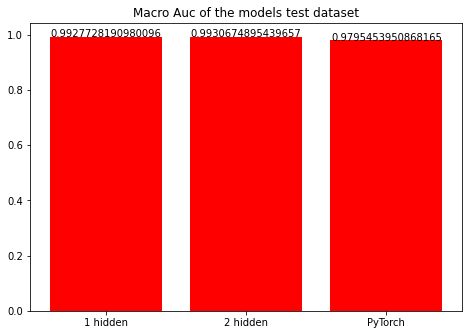

In [ ]:
print("Summary accuracy")
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['1 hidden', '2 hidden', 'PyTorch']
acc = [macro_auc_1Hidden,macro_auc_2Hidden, macro_auc_pytorc]
ax.bar(langs,acc, color = 'red', )
# plt.ylim(0.4)

for i in range(len(langs)):
    plt.text(i,acc[i],acc[i],  ha = 'center')
plt.title("Macro Auc of the models test dataset")  
plt.show()